In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data2018= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PL_Datasets/2018-19.csv')
data2019= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PL_Datasets/2019-20.csv')
data2020= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PL_Datasets/2020-2021.csv')
data2021= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PL_Datasets/2021-2022.csv')

In [ ]:
import pandas as pd

def load_match_data(path):
    df = pd.read_csv(path, parse_dates=['Date'], dayfirst=True)
    return df

def determine_winner(df):
    """Add 'Result' column: 'H'=Home win, 'D'=Draw, 'A'=Away win."""
    def _res(r):
        if r['FTHG'] > r['FTAG']: return 'H'
        if r['FTAG'] > r['FTHG']: return 'A'
        return 'D'
    df['Result'] = df.apply(_res, axis=1)
    return df

def calculate_win_streaks(df):
    """Compute positive/negative win/loss streaks for Home and Away teams."""
    def _streak(series, win_label, loss_label):
        out, cur = [], 0
        for v in series:
            if v == win_label: cur = cur+1 if cur>0 else 1
            elif v == loss_label: cur = cur-1 if cur<0 else -1
            else: cur = 0
            out.append(cur)
        return out

    home = df[['Date','HomeTeam','Result']].copy()
    home['Outcome'] = home['Result'].map({'H':'W','D':'D','A':'L'})
    home = home.sort_values(['HomeTeam','Date'])
    home['HomeStreak'] = home.groupby('HomeTeam')['Outcome'] \
                             .transform(lambda s: pd.Series(_streak(s,'W','L')))
    away = df[['Date','AwayTeam','Result']].copy()
    away['Outcome'] = away['Result'].map({'A':'W','D':'D','H':'L'})
    away = away.sort_values(['AwayTeam','Date'])
    away['AwayStreak'] = away.groupby('AwayTeam')['Outcome'] \
                             .transform(lambda s: pd.Series(_streak(s,'W','L')))
    df = df.merge(home[['Date','HomeTeam','HomeStreak']], on=['Date','HomeTeam'])
    df = df.merge(away[['Date','AwayTeam','AwayStreak']], on=['Date','AwayTeam'])
    return df

def calculate_rolling_features(df, stat_cols, window=5):
    df = df.sort_values('Date').reset_index(drop=True)
    for col in stat_cols:
        df[f'Home_{col}_avg{window}'] = (
            df.groupby('HomeTeam')[col]
              .rolling(window, min_periods=1)
              .mean().shift(1)
              .reset_index(level=0, drop=True)
        )
        df[f'Away_{col}_avg{window}'] = (
            df.groupby('AwayTeam')[col]
              .rolling(window, min_periods=1)
              .mean().shift(1)
              .reset_index(level=0, drop=True)
        )
    return df

base_path = '/content/drive/MyDrive/Colab Notebooks/PL_Datasets/'
data2018 = load_match_data(base_path + '2018-19.csv')
data2019 = load_match_data(base_path + '2019-20.csv')
data2020 = load_match_data(base_path + '2020-2021.csv')
data2021 = load_match_data(base_path + '2021-2022.csv')

# COMBINE TRAINING DATASETS INTO ONE LARGE DATASET
train = pd.concat([data2018, data2019, data2020], ignore_index=True)

#APPLY PRE-PROCESSING FUNCTIONS
train = determine_winner(train)
train = calculate_win_streaks(train)
stat_cols = ['FTHG','FTAG','HS','AS','HST','AST','HC','AC','HF','AF','HY','AY','HR','AR']
train = calculate_rolling_features(train, stat_cols, window=5)

train.head()



<ipython-input-6-bd1a935bf259>:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, parse_dates=['Date'], dayfirst=True)


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,Home_AF_avg5,Away_AF_avg5,Home_HY_avg5,Away_HY_avg5,Home_AY_avg5,Away_AY_avg5,Home_HR_avg5,Away_HR_avg5,Home_AR_avg5,Away_AR_avg5
0,E0,2018-08-10,Man United,Leicester,2,1,H,1,0,H,...,10.2,11.0,1.6,1.4,1.2,1.6,0.0,0.0,0.2,0.2
1,E0,2018-08-11,Bournemouth,Cardiff,2,0,H,1,0,H,...,11.6,8.4,1.2,1.4,1.4,1.0,0.4,0.0,0.4,0.0
2,E0,2018-08-11,Fulham,Crystal Palace,0,2,A,0,1,A,...,10.8,10.2,0.8,1.8,1.6,1.4,0.0,0.2,0.0,0.2
3,E0,2018-08-11,Huddersfield,Chelsea,0,3,A,0,2,A,...,9.8,9.6,1.0,0.6,0.4,1.2,0.0,0.0,0.0,0.2
4,E0,2018-08-11,Newcastle,Tottenham,1,2,A,1,2,A,...,11.6,8.8,1.6,0.6,1.4,1.2,0.0,0.0,0.0,0.0


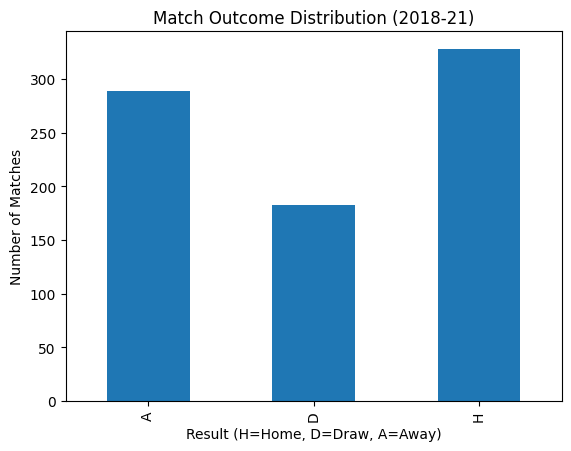

In [ ]:
import matplotlib.pyplot as plt

counts = train['Result'].value_counts().sort_index()
plt.figure()
counts.plot(kind='bar')
plt.title('Match Outcome Distribution (2018-21)')
plt.xlabel('Result (H=Home, D=Draw, A=Away)')
plt.ylabel('Number of Matches')
plt.show()

Interesting / Breakdown, there is a relative balance, of Wins / Losses/ Draws. This should make for a balanced dataset, but interestingly (as you will see later the precisionof the draw is very low) as compared to wins / losses

In [ ]:


import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder


# 1) Derive Season_start for splitting
train['Season_start'] = train['Date'].dt.year.where(
    train['Date'].dt.month >= 8,
    train['Date'].dt.year - 1
)

# 2) Split into training (2018-19 & 2019-20) and validation (2020-21)
train_set = train[train['Season_start'] < 2020]
val_set   = train[train['Season_start'] == 2020]

# 3) Define feature columns: 5-game rolling averages + streaks
rolling_feats = [col for col in train.columns if ('_avg5' in col)]
streak_feats  = ['HomeStreak', 'AwayStreak']
feature_cols  = rolling_feats + streak_feats

# 4) Prepare X and y
# Create 'Result_enc' column using Label Encoding for the 'Result' column
le = LabelEncoder()
train_set['Result_enc'] = le.fit_transform(train_set['Result'])
val_set['Result_enc'] = le.transform(val_set['Result'])


X_train = train_set[feature_cols]
y_train = train_set['Result_enc']
X_val   = val_set[feature_cols]
y_val   = val_set['Result_enc']

# 5) Fit Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 6) Predictions
y_pred_train = rf.predict(X_train)
y_pred_val   = rf.predict(X_val)

# 7) Evaluate
print("Training Accuracy   :", accuracy_score(y_train, y_pred_train))
print("Validation Accuracy :", accuracy_score(y_val,   y_pred_val))
print("\nValidation Classification Report:\n", classification_report(y_val, y_pred_val))

<ipython-input-8-7c15302e0dac>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['Result_enc'] = le.fit_transform(train_set['Result'])
<ipython-input-8-7c15302e0dac>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_set['Result_enc'] = le.transform(val_set['Result'])


Training Accuracy   : 1.0
Validation Accuracy : 0.47368421052631576

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.46      0.49       153
           1       0.15      0.05      0.07        83
           2       0.48      0.74      0.58       144

    accuracy                           0.47       380
   macro avg       0.39      0.41      0.38       380
weighted avg       0.43      0.47      0.43       380



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Extract importances and wrap in a DataFrame
feat_imp = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_

    }).sort_values('importance', ascending=True)

feat_imp.head()



,feature,importance
28,HomeStreak,0.003172
29,AwayStreak,0.004338
25,Away_HR_avg5,0.009752
27,Away_AR_avg5,0.010202
26,Home_AR_avg5,0.010424


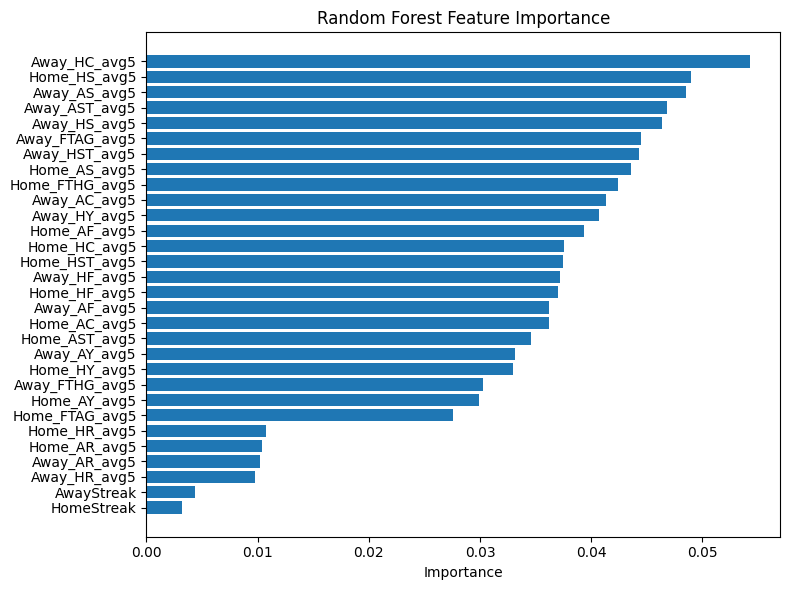

In [ ]:
# 2. Plot
plt.figure(figsize=(8,6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()